# Feature Cross-Correlation Analysis

This script analyzes the features generated by the `create_features` function from `src/xgboost_price_reversal.py`. A heatmap of the cross-correlation matrix will be generated to visualize the relationships between different technical indicators. This helps in identifying multicollinearity, which can be an issue for some machine learning models.

## 1. Load Data and Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Set plot style
sns.set(style="whitegrid")

# Add src directory to path to allow for module import
sys.path.append('src')
try:
    from rf_price_reversal import create_features
    print("Successfully imported create_features from rf_price_reversal.")
except ImportError as e:
    print(f"Error importing create_features: {e}")
    print("Please ensure the script is run from the project root directory.")

Successfully imported create_features from rf_price_reversal.


## 2. Load and Prepare Data

In [13]:
DATA_PATH = 'data/BTCUSDT_1h.csv'
df = pd.read_csv(DATA_PATH)

# Convert to datetime and set as index
df['timestamp'] = pd.to_datetime(df['date'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

print("Data loaded and prepared. Shape:", df.shape)

Data loaded and prepared. Shape: (88780, 13)


## 3. Generate Features and Analyze Correlations

In [14]:
# Generate features
# The create_features function expects capitalized column names
df_for_features = df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

print("Generating features...")
features_df = create_features(df_for_features)
# Drop rows with NaNs that might have been created by indicators with larger windows
features_df.dropna(inplace=True)
print("Features generated. Shape:", features_df.shape)

# It's good practice to drop columns with no variance before correlation
features_df = features_df.loc[:, features_df.apply(pd.Series.nunique) != 1]
print(f"Shape after removing constant columns: {features_df.shape}")

Generating features...


/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/src/rf_price_reversal.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prev = close.shift(1).fillna(method='bfill')


Features generated. Shape: (88780, 63)
Shape after removing constant columns: (88780, 63)


Calculating feature correlation matrix...
Plotting correlation heatmap...


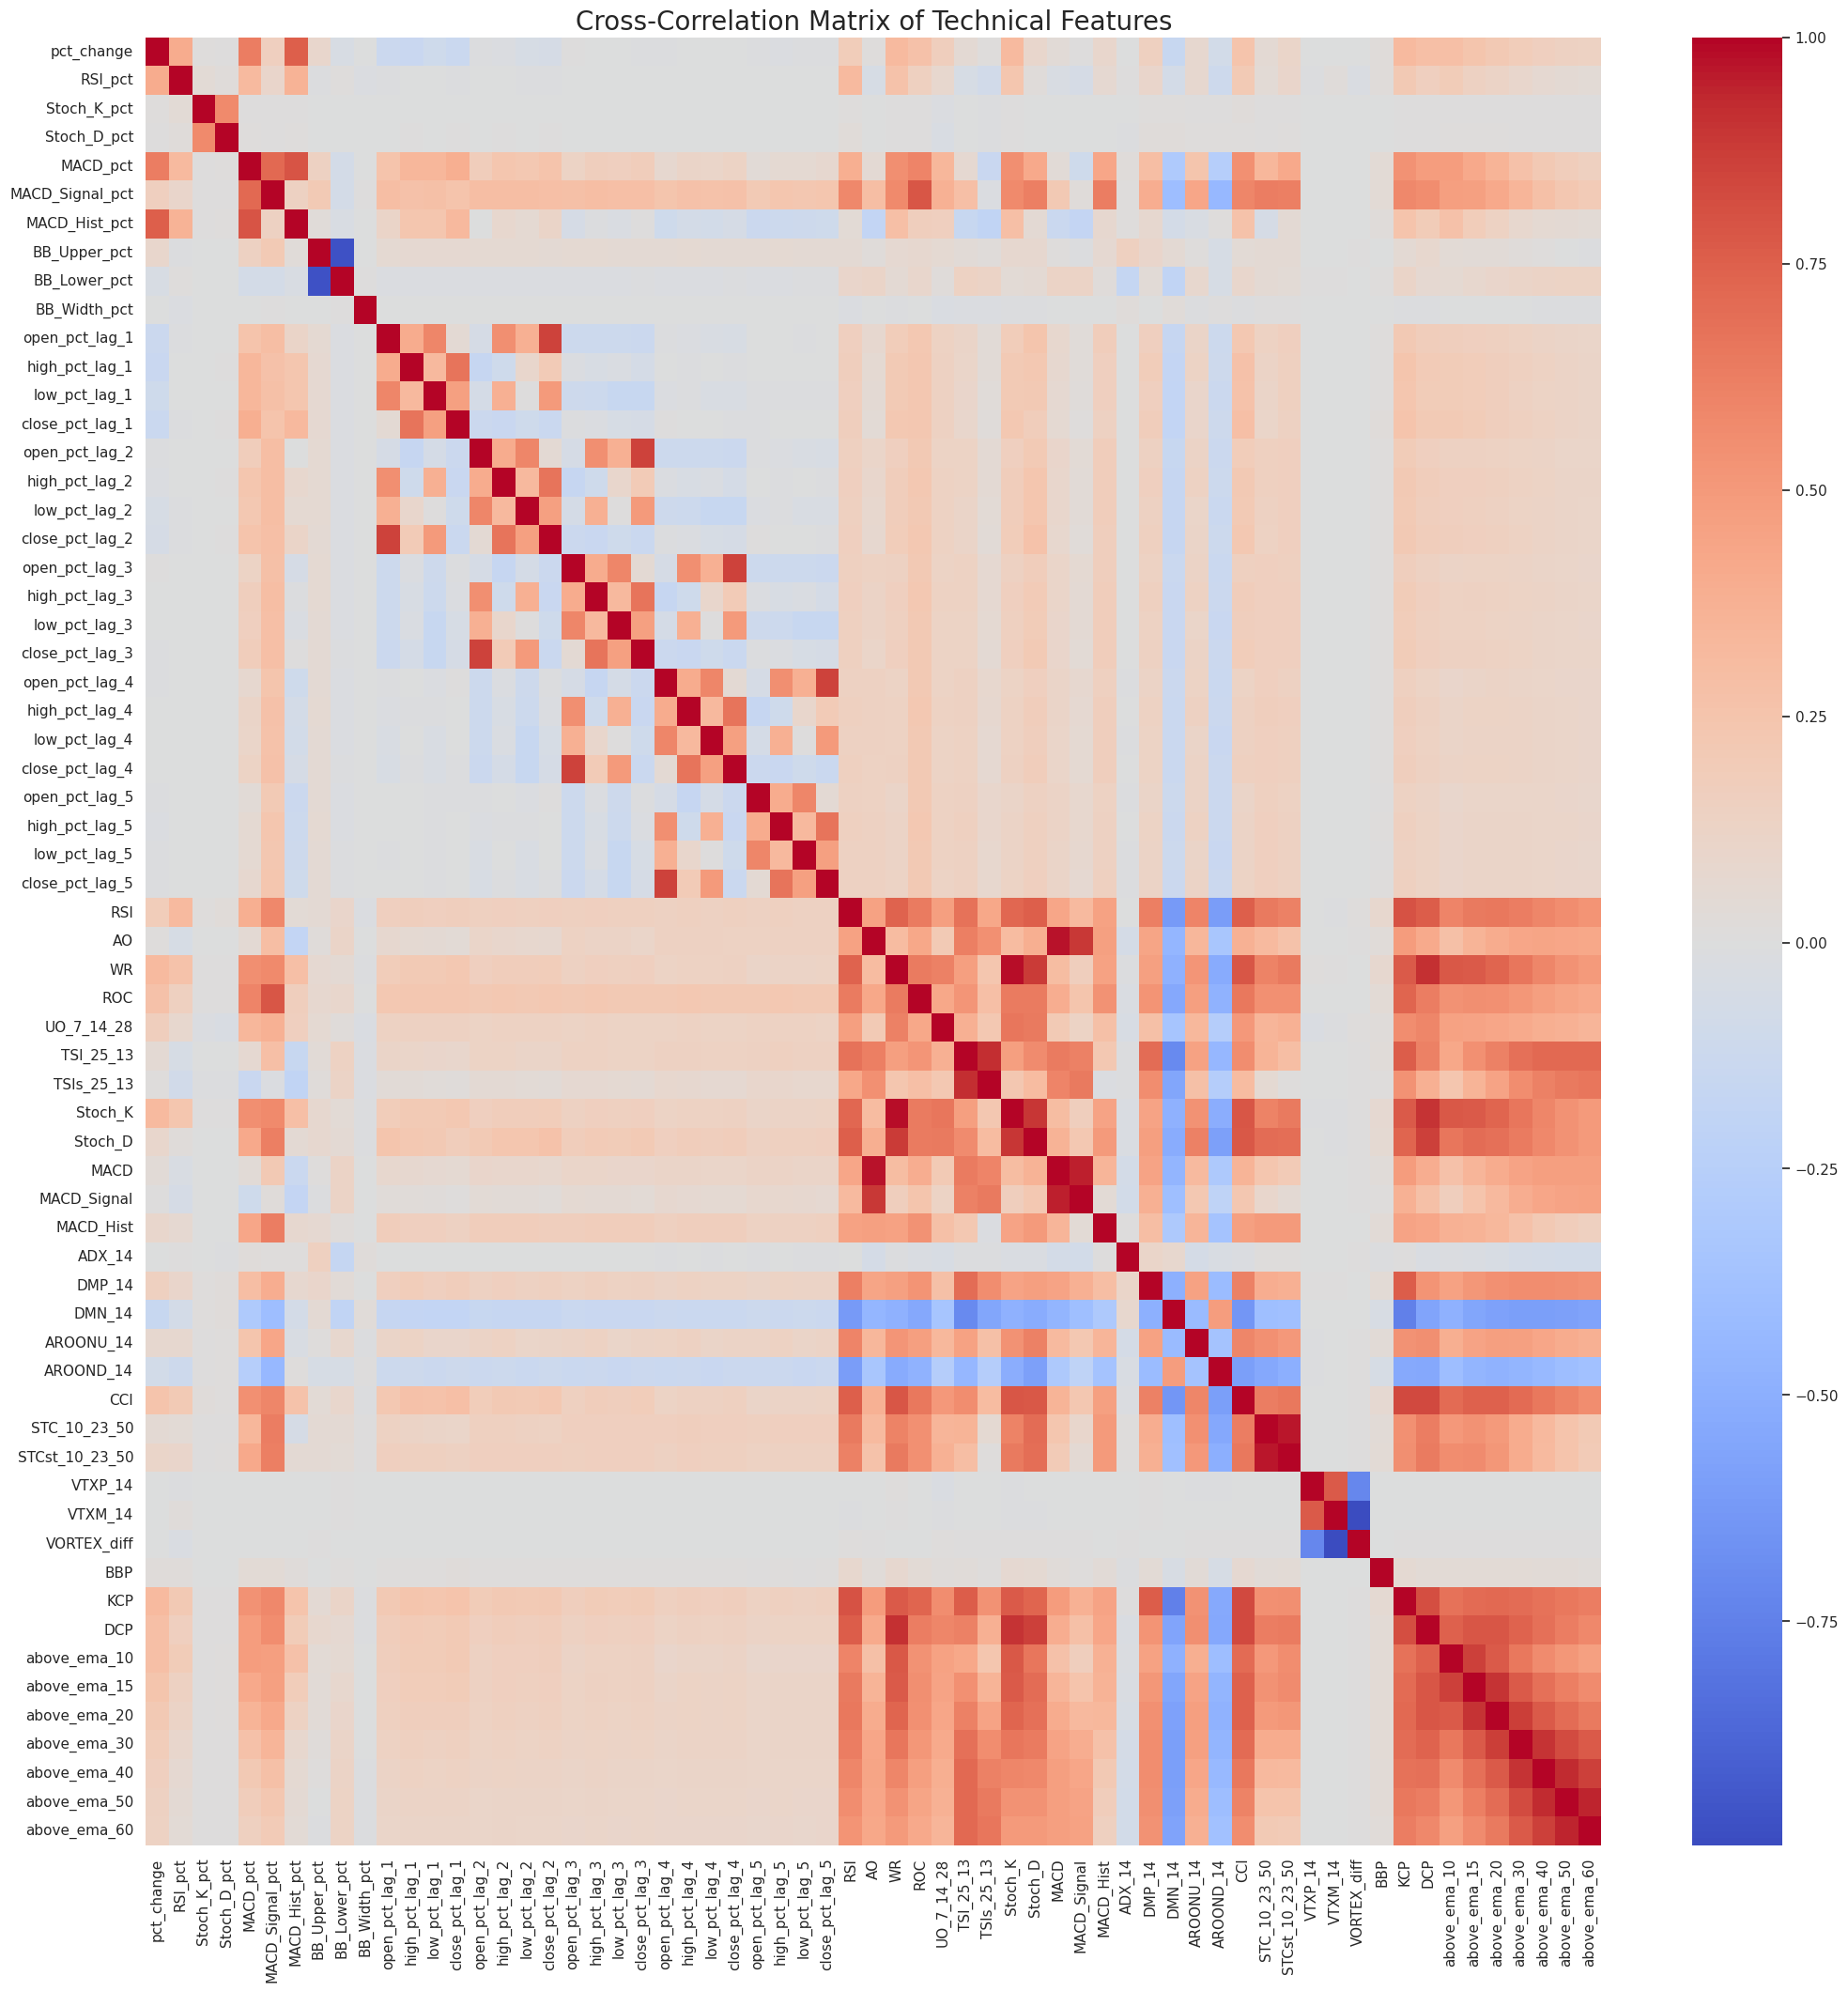

In [15]:
# Calculate and plot the correlation matrix
print("Calculating feature correlation matrix...")
correlation_matrix = features_df.corr()

print("Plotting correlation heatmap...")
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Cross-Correlation Matrix of Technical Features', fontsize=20)
plt.show()

### 3.1. Most and Least Correlated Features
We can also inspect the correlation matrix numerically to find the pairs of features with the highest and lowest correlations.

In [16]:
# Get absolute correlations and remove self-correlations
abs_corr = correlation_matrix.abs()
# Set diagonal to NaN to ignore self-correlation of 1
np.fill_diagonal(abs_corr.values, np.nan)

# Unstack the matrix to get a Series of correlations, then drop NaNs
corr_pairs = abs_corr.unstack().dropna()

# --- Find and print most correlated pairs ---
print("--- Top 10 Most Correlated Feature Pairs ---")
sorted_pairs = corr_pairs.sort_values(ascending=False)
seen_most = set()
top_pairs = []
for index, value in sorted_pairs.items():
    # Use a sorted tuple to represent the pair to handle duplicates (A,B) vs (B,A)
    pair = tuple(sorted(index))
    if pair not in seen_most:
        top_pairs.append((index, value))
        seen_most.add(pair)
    if len(top_pairs) >= 10:
        break
for (feat1, feat2), corr in top_pairs:
    print(f"{feat1:<30} | {feat2:<30} | {corr:.4f}")


# --- Find and print least correlated pairs ---
print("\n--- Top 10 Least Correlated Feature Pairs ---")
sorted_pairs_asc = corr_pairs.sort_values(ascending=True)
seen_least = set()
bottom_pairs = []
for index, value in sorted_pairs_asc.items():
    # Use a sorted tuple to represent the pair to handle duplicates (A,B) vs (B,A)
    pair = tuple(sorted(index))
    if pair not in seen_least:
        bottom_pairs.append((index, value))
        seen_least.add(pair)
    if len(bottom_pairs) >= 10:
        break
for (feat1, feat2), corr in bottom_pairs:
    print(f"{feat1:<30} | {feat2:<30} | {corr:.4f}")

--- Top 10 Most Correlated Feature Pairs ---
VTXM_14                        | VORTEX_diff                    | 0.9972
Stoch_K                        | WR                             | 0.9789
MACD                           | AO                             | 0.9724
BB_Upper_pct                   | BB_Lower_pct                   | 0.9717
STCst_10_23_50                 | STC_10_23_50                   | 0.9612
MACD_Signal                    | MACD                           | 0.9519
above_ema_60                   | above_ema_50                   | 0.9394
above_ema_40                   | above_ema_50                   | 0.9229
TSI_25_13                      | TSIs_25_13                     | 0.9198
WR                             | DCP                            | 0.9096

--- Top 10 Least Correlated Feature Pairs ---
KCP                            | VTXP_14                        | 0.0000
VORTEX_diff                    | Stoch_K_pct                    | 0.0000
VTXM_14                        |

### Analysis
The heatmap above visualizes the Pearson correlation coefficient between each pair of features.
- **Red colors** indicate a strong positive correlation (when one feature increases, the other tends to increase).
- **Blue colors** indicate a strong negative correlation (when one feature increases, the other tends to decrease).
- **Colors close to white** indicate a weak or no linear correlation.

Clusters of red and blue show groups of highly correlated features, suggesting redundancy. For example, many momentum indicators might move together, and different calculations for trend might yield similar signals.